## Instructions {-}
Ce sujet est constitué de deux parties : la partie 1 correspond au sujet donné l'an dernier, dont la correction vous est donnée, la partie 2 constitue la partie qui sera évaluée et se place dans la continuité de la partie 1.

# Enoncé du problème (Partie 1)

L'objectif de ce projet est d'estimer la longueur de câble sous-marin nécessaire pour relier deux côtes $A$ et $B$  en utilisant des simulations conditionnelles.


Le câble reposera sur le fond marin dont la profondeur est inconnue.
Le segment $[AB]$ est discrétisé par une séquence de (N+1) points. On pose $x_0=A$ et pour $i=1,\dots,N$, $$x_i=x_0+i\Delta$$ où $$\Delta = \frac{AB}{N}$$ de telle sorte que $x_N=B$.
On note $z(x)$ la profondeur du fond marin au point $x$ de telle sorte 
qu'on pourra estimer la longueur totale de câble nécessaire par la somme 
des longueurs sur les segments de la discrétisation :

$$l=\sum_{i=1}^N\sqrt{\Delta^2+(z(x_i)-z(x_{i-1}))^2}.$$

Enfin, notons que l'on dispose d'un ensemble de $n$ observations de la 
profondeur que l'on supposera situées sur des points de discrétisation $z(x_{j_1}),\dots,z(x_{j_n})$.


On adopte un modèle probabiliste pour la profondeur. On suppose que le vecteur des 
profondeurs sur les points de discrétisation 
$\mathbf{z}=(z(x_0),\dots,z(x_N))$ est la réalisation
d'un vecteur aléatoire gaussien $\mathbf{Z}=(Z(x_0),\dots,Z(x_N))$ 
dont le vecteur d'espérance ne contient qu'une seule valeur $\mu$ 
répétée $N+1$ fois et dont la matrice de covariance $\Sigma$ a pour termes $\sigma_{ij}$
définis par $\sigma_{ij}=C(|x_i-x_j|)$ où $C$ est une
fonction décroissante, traduisant le fait que deux points 
géographiquement proches ont tendance à avoir des profondeurs plus similaires que deux points éloignés.

On supposera que la matrice de covariance ainsi 
générée est définie-positive (en fait, $C$ sera choisie parmi les fonctions qui, 
appliquées aux termes d'une matrice de distance, produisent des matrices définie-positives). 

Si on note $L$ la variable aléatoire donnant la longueur de cable nécessaire : 
$$L=\sum_{i=1}^N\sqrt{\Delta^2+(Z(x_i)-Z(x_{i-1}))^2},$$
un bon estimateur de $L$ est fourni par l'espérance conditionnelle 

$$L^\star=E[L|Z(x_{j_1})=z(x_{j_1}),\dots,Z(x_{j_n})=z(x_{j_n})].$$
                                                                              
Cependant, cette quantité est difficilement accessible par le calcul. 
On va donc avoir recours à des
simulations conditionnelles. C'est-à-dire que l'on va simuler 
un nombre $K$ de réalités (disons des réalisations du modèle 
probabiliste choisi), et sur chacune d'entre elle, 
la quantité de câble nécessaire sera évaluée. 
On disposera ainsi d'un échantillon $l_{(1)},\dots,l_{(K)}$ de 
longueures simulées. Puis on approchera l'espérance conditionnelle  par 
$$L^\star=\frac1{K}\sum_{k=1}^K l_{(k)}.$$

L'objectif de ce projet est donc d'écrire un code permettant 
d'effectuer cette simulation conditionnelle, puis de l'appliquer 
au jeu de données fourni et d'en déduire une estimation de la longueur de câble nécessaire.

## Questions théoriques

1. Quel théorème du cours nous autorise-t-il à estimer l'espérance conditionnelle par la moyenne empirique de simulations conditionnelles ?

*la loi forte des grands nombres, cf [Proba IV p.16](https://boisgera.github.io/CDIS/output/Probabilit%C3%A9%20IV.pdf), en vérifiant que $L$ est bien intégrable*

2. Rappeler la loi conditionnelle du vecteur des composantes de $\mathbf{Z}$ correspondant aux points de discrétisation
sans observation, connaissant les valeurs prises par les composantes aux sites d'observation.

*cf. [Proba III p.18](https://boisgera.github.io/CDIS/output/Probabilit%C3%A9%20III.pdf),*

3. Si $\mathbf{Y}=(Y_1,\dots,Y_p)$ est un vecteur de composantes gaussiennes indépendantes, toutes d'espérance nulle et de variance 1, 
quelle est la loi du vecteur $\mathbf{Z}=m+R\mathbf{Y}$ où $R$ est une matrice $p\times p$ et $m$ est un vecteur de taille $p$ ?

*cf. [Proba V p.12](https://cloud.mines-paristech.fr/index.php/s/GLDwtTAMOJCYk3i/download)*

4. En déduire un algorithme de simulation conditionnelle.

*Appliquer l'algorithme de la q.3 à la loi conditionnelle (on calculera en particulier l'espérance conditionnelle de $\mathbf{Z}$ sachant les données et la décomposition de Cholesky de la matrice de covariance conditionnelle sachant les données).*

## Données du problème
Conventionnellement, $A$ est l'origine, $B=500$, $N=100$.

Les données $$\begin{array}{c|r}i & z(x_i)\\
\hline
0 & 0\\
20 & -4\\
40 & -12.8\\
60 & -1\\
80 & -6.5\\
100 & 0\end{array}$$

L'espérance de chaque composante du vecteur aléatoire $\mathbf{Z}$ est donnée par $\mu=-5.$

La fonction $C$ est définie par $$C(h)=\sigma^2 e^{-|h|/a},$$

où $|h|$ correspond à la distance entre deux points, $a=50$ et $\sigma^2=12$.


## Implémentation

### Préambule

In [42]:
#Chargement de dépendances

import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad 

#Discrétisation
A=0
B=500
N=101 #Nombre de points de discrétisation
Delta = (B-A)/(N-1)
discretization_indexes = np.arange(N)
discretization = discretization_indexes*Delta
#Paramètres du modèle

mu=-5
a = 50
sigma2 = 12

#Données

observation_indexes = [0,20,40,60,80,100]
depth = np.array([0,-4,-12.8,-1,-6.5,0])

#Indices des composantes correspondant aux observations et aux componsantes non observées

unknown_indexes=list(set(discretization_indexes)-set(observation_indexes))


### Questions

1. Ecrire une fonction qui prend en argument la distance entre les points, le paramètre $a$, et le paramètre $\sigma^2$, et qui retourne la covariance entre deux points.
On pourra fournir une matrice de distance à cette fonction. Dans ce cas, la fonction renverra la matrice de covariance.

In [43]:
#Fonction C

def Covexp(dist,rangeval,sigmaval):
    return sigmaval * np.exp(-dist/rangeval)


2. Calculer la matrice de distance.

In [44]:
distmat=abs(np.subtract.outer(discretization,discretization))

3. Calculer la matrice de covariance du vecteur $\mathbf{Z}=(Z(x_0),\dots,Z(x_N))$.

In [45]:
Sigma=Covexp(distmat,a,sigma2)

4. Extraire les 3 matrices de covariance suivantes :

 * entre les observations

 * entre les observations et les inconnues

 * entre les inconnues


In [46]:
SigmaObs = Sigma[observation_indexes,:][:,observation_indexes]
SigmaObsUnknown = Sigma[observation_indexes,:][:,unknown_indexes]
SigmaUnknown = Sigma[unknown_indexes,:][:,unknown_indexes]

5. Calculer l'espérance conditionnelle des composantes non observées connaissant les observations et la représenter avec les données.

In [47]:
invSigma = np.linalg.inv(SigmaObs) 
Ec= mu+np.matmul(np.transpose(SigmaObsUnknown),np.matmul(np.linalg.inv(SigmaObs),depth-mu))

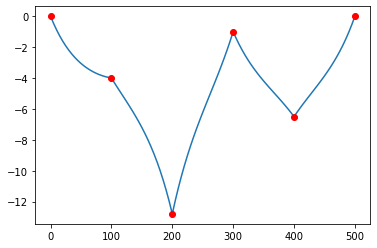

In [48]:
allval1 = np.zeros(N)
allval1[unknown_indexes]=Ec
allval1[observation_indexes]=depth
plt.plot(discretization,allval1)
plt.plot(discretization[observation_indexes], depth, 'ro')
plt.show()

6. Calculer la matrice de variance conditionnelle et tracer sa diagonale (variance conditionnelle) en fonction de la position. Commenter.

In [49]:
SigmaCond = SigmaUnknown - np.matmul(np.transpose(SigmaObsUnknown),np.matmul(np.linalg.inv(SigmaObs),SigmaObsUnknown))

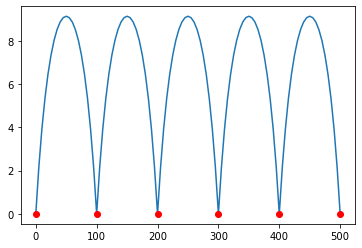

In [50]:
allval2 = np.zeros(N)
allval2[unknown_indexes]=np.diag(SigmaCond)
plt.plot(discretization,allval2)
plt.plot(discretization[observation_indexes], np.zeros(np.shape(observation_indexes)[0]), 'ro')
plt.show()

*On voit ici que la variance est nulle aux points de données (puisque la valeur est fixée) puis qu'elle augmente lorsqu'on s'éloigne des données*

7. Effectuer une simulation conditionnelle. Sur un même graphique, tracer la simulation ainsi que les données et l'espérance conditionnelle. Commenter.

In [51]:
Cholesky = np.linalg.cholesky(SigmaCond)

x = np.random.normal(0,1,np.shape(unknown_indexes)[0])
simu = Ec + np.matmul(Cholesky,x)

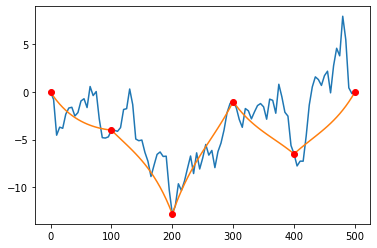

In [52]:
allval3 = np.zeros(N)
allval3[unknown_indexes]=simu
allval3[observation_indexes]=depth
plt.plot(discretization,allval3)
plt.plot(discretization,allval1)
plt.plot(discretization[observation_indexes], depth, 'ro')
plt.show()

*l'espérance conditionnelle est lisse car c'est la fonction des données qui minimise la variance ; la simulation conditionnelle reproduit les fluctuations du modèle et donc l'aspect du fond marin*

8. Ecrire une fonction qui calcule la longueur du câble en fonction du vecteur des profondeurs et du pas de discrétisation.

In [53]:
def length(z,delta):
    return sum(np.sqrt(Delta**2+(z[1:N]-z[0:-1])**2))

9. Utiliser cette fonction pour calculer la longueur du câble à partir de 100 simulations. Comparer l'espérance conditionnelle (estimée) de la longueur avec la longueur de l'espérance conditionnelle.

In [54]:
K=100000
result = np.zeros(K)
for i in range(K):
    x=np.random.normal(0,1,np.shape(unknown_indexes)[0])
    allval3[unknown_indexes]=Ec + np.matmul(Cholesky,x)
    result[i]=length(allval3,Delta)


In [55]:
sum(result)/K

522.4469214186591

In [56]:
length(allval1,Delta)

501.6468416918411

*On donne ici directement les résultats pour 100000 simulations (comparer la vitesse d'éxécution avec votre code pour voir l'intérêt de la vectorisation).*

*On voit ici que la longueur donnée par l'espérance conditionnelle est bien moindre que la longueur d'une simulation conditionnelle. Ceci est dû au fait que la simulation conditionnelle va reproduire les fluctuations attendues, au contraire de l'espérance conditionnelle qui minimise la variance.*

*NB : On remarquera que c'est le seul endroit où on a utilisé une boucle dans cette correction. On aurait pu s'en passer en utilisant notamment les outils de la librairie Pandas mais le code est plus lisible ainsi.*

10. Représenter la suite $M_n$ des moyennes des longueurs de câbles en fonction du nombre de simulations. Commenter.

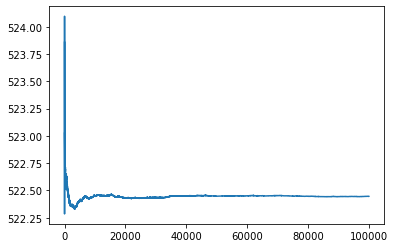

In [57]:
indice_simu = 1+np.arange(K)
plt.plot(indice_simu,np.cumsum(result)/indice_simu)
plt.show()

*Comme attendu d'après la LFGN, on observe une stabilisation de la valeur moyenne. Les variations sont imperceptibles après quelques dizaines de milliers de simulations*

11. Représenter l'histogramme des longueurs de câbles générées.

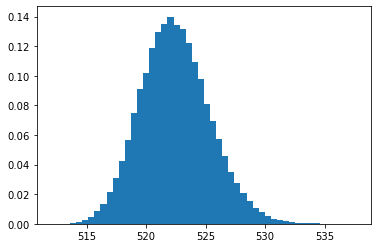

In [58]:
plt.hist(result,50,density=True)
plt.show()

*L'histogramme ressemble à une densité gaussienne, avec néanmoins une légère dissymétrie (plus de valeurs fortes).*

12. Donner un intervalle de confiance à 95% de la longueur du câble par 2 méthodes différentes. Commenter.

*1ère méthode : par approximation gaussienne. L'histogramme précédent suggère qu'une loi gaussienne peut bien représenter la loi conditionnelle de la longueur du cable. On obtient un intervalle de confiance en calculant la moyenne (milieu de l'intervalle) et l'écart type de l'échantillon de longueurs de câble puis en appliquant la formule du cours.*

In [59]:
Ln = sum(result)/K
sigman = np.std(result)
[Ln - sigman*1.96,Ln + sigman*1.96]

[516.7663655006278, 528.1274773366905]

*2e méthode : on extrait les quantiles à 2.5% et 97.5% de l'échantillon, c'est-à-dire les valeurs $x_\alpha$ pour $\alpha \in \{0.025 ; 0.975\}$telles que* $$\mathbb{P}(L<x_\alpha) \approx \frac{1}{n}\sum_{i=1}^N 1_{\{L_i<x_\alpha\}}$$

In [60]:
np.quantile(result,[0.025,0.975])

array([517.11009098, 528.45989136])

*ATTENTION : ici l'utilisation du TCL tel qu'exposé au début du chapitre 5 fournissait un intervalle de confiance de l'**espérance de la longueur de câble** et non de la **longueur de câble** (erreur fréquente).*

*On voit par ailleurs que la 2e méthode est plus précise car elle est basée directement sur la loi empirique de l'échantillon*

13. Donner une estimation de la probabilité que la longueur du câble dépasse 525 m.

In [61]:
np.mean(result>525)

0.18607

14. Reprendre les questions précédentes avec 1000, 10000 puis 100000 simulations. Commenter

*cf. le commentaire de la question 10. On observe une stabilisation progressive des estimateurs des différentes quantités calculées : moyennes, quantiles, probabilité de dépassement de seuil.*

# Enoncé 2021 (Partie 2)

Nous nous plaçons dans le même cadre que ci-dessus. Nous tenons pour acquis les résultats précédents et allons maintenant approfondir l'analyse.

## Valeurs positives

1. A la question 7 de la partie 1, on peut s'apercevoir que certains profils de profondeur présentent des valeurs positives, ce qui n'a pas de sens si on considère qu'il n'y a pas de partie émergée entre les deux côtes. Proposer et implémenter un algorithme de type rejet qui ne génèrera que des valeurs négatives. Représenter un profil de profondeur généré.

In [62]:
def neg_profondeur(esp):
    x = np.random.normal(0,1,np.shape(unknown_indexes)[0])
    prof = esp + np.matmul(Cholesky,x)
    while(np.any(prof>0)):
        x = np.random.normal(0,1,np.shape(unknown_indexes)[0])
        prof = esp + np.matmul(Cholesky,x)
    return prof

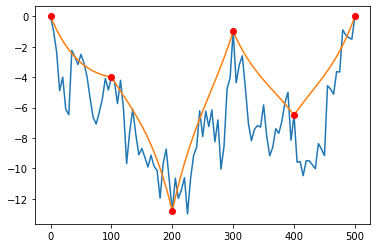

In [63]:
simu_profondeur =neg_profondeur(Ec)

allval3 = np.zeros(N)
allval3[unknown_indexes] = simu_profondeur
allval3[observation_indexes] = depth
plt.plot(discretization,allval3)
plt.plot(discretization,allval1)
plt.plot(discretization[observation_indexes], depth, 'ro')
plt.show()    

2. L'emploi de cet algorithme a-t-il un impact sur la valeur moyenne de la longueur de câble ? Sur l'histogramme des longueurs de câble ? Sur l'intervalle de confiance obtenu par la méthode des quantiles ? Sur la probabilité de dépassement du seuil de 525 m? Donner une estimation du taux de rejet de l'algorithme. Considérer 10000 simulations.

In [64]:
def neg_profondeur2(esp):
    x = np.random.normal(0,1,np.shape(unknown_indexes)[0])
    prof = esp + np.matmul(Cholesky,x)
    i=0
    if(np.any(prof > 0)):
        i+=1
        x = np.random.normal(0,1,np.shape(unknown_indexes)[0])
        prof = esp + np.matmul(Cholesky,x)
    while(np.any(prof > 0)):
        x = np.random.normal(0,1,np.shape(unknown_indexes)[0])
        prof = esp + np.matmul(Cholesky,x)
    return prof, i

In [65]:
K=10000
result = np.zeros(K)
rejet = np.zeros(K)
for i in range(K):
    simu_prof2, j = neg_profondeur2(Ec)
    allval3[unknown_indexes] = simu_prof2
    result[i] = length(allval3,Delta)
    rejet[i] = j

In [66]:
sum(result)/K

521.8116978985274

In [67]:
np.mean(result>525)

0.1308

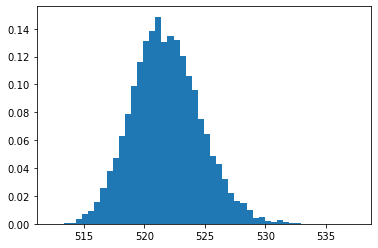

In [68]:
plt.hist(result,50,density=True)
plt.show()

In [69]:
np.quantile(result,[0.025,0.975])

array([516.69967002, 527.67943575])

En empêchant les profondeurs d'être positives, on obtient une longueur moyenne de corde et une probabilité de dépassement des 525m de corde légèrement inférieure à celles calculées avant. De plus, l'intervalle de confiance et l'histogramme sont très légèrement décallés vers la gauche.

In [70]:
sum(rejet)/K

0.9599

On trouve un taux de rejet de l'algorithme d'environ 0,96.

## Approche Bayésienne

Dans la première partie, on a considéré que l'ensemble des paramètres du modèle était parfaitement connu. Toutes choses égales par ailleurs, on va maintenant considérer que la moyenne $\mu$ est issue d'une estimation entâchée d'une incertitude. Plus précisément, on va modéliser cette incertitude en considérant que $\mu \sim \mathcal{N}(-5,4)$.

On va également décomposer le vecteur $\mathbf{Z}$ en $\mathbf{Z} = (\mathbf{Z}_{\text{OBS}},\mathbf{Z}_{\text{UNK}})$. On notera $C_{\text{OBS}}$ et $C_{\text{UNK}}$ les matrices de covariance respectives de $\mathbf{Z}_{\text{OBS}}$ et $\mathbf{Z}_{\text{UNK}}$ ainsi que $C_{\text{OBS},\text{UNK}}$ la matrice des covariances entre ces deux vecteurs.

### Questions théoriques

3. Montrer que $\mu | \mathbf{Z}_{\text{OBS}}= \mathbf{z}_{\text{OBS}} \sim \mathcal{N}(\widehat{\mu},\widehat{\sigma}^2)$ avec
$$\widehat{\sigma}^2 = (\mathbf{1}^t C_{\text{OBS}}^{-1} \mathbf{1} + \frac1{4})^{-1},$$ 
où $\mathbf{1}$ est un vecteur de longueur 6 (soit la longueur du vecteur $\mathbf{Z}_{\text{OBS}}$) ne contenant que des 1 et 
$$\widehat{\mu} = \widehat{\sigma}^2 (\mathbf{1}^t C_{\text{OBS}}^{-1} \mathbf{z}_{\text{OBS}} - \frac{5}{4} )$$
Indication : écrire la densité jointe du vecteur $(\mathbf{Z}_{\text{OBS}},\mu)$, calculer $-2 \ln$ de cette densité puis identifier la forme quadratique faisant intervenir $\mu$.

**Réponse 3**

$$f_{\mathbf{Z}_{\text{OBS}},\mu}(\mathbf{z}_{\text{OBS}},\widehat{\mu}) = f_{\mathbf{Z}_{\text{OBS}}|\mu=\widehat{\mu}}(\mathbf{z}_{\text{OBS}})f_{\mu}(\widehat{\mu})$$\
et\
$$f_{\mathbf{Z}_{\text{OBS}},\mu}(\mathbf{z}_{\text{OBS}},\widehat{\mu}) = f_{\mu|\mathbf{Z}_{\text{OBS}}=\mathbf{z}_{\text{OBS}}}(\widehat{\mu})f_{\mathbf{Z}_{\text{OBS}}(\mathbf{z}_{\text{OBS}}})$$

avec      $\mathbf{Z}_{\text{OBS}} | \mu = \widehat{\mu} \sim \mathcal{N}(\widehat{\mu},C_{\text{OBS}})$ et $\mu \sim \mathcal{N}(-5,4)$

D'où\
$$-2\ln(f_{\mathbf{Z}_{\text{OBS}},\mu}(\mathbf{z}_{\text{OBS}},\widehat{\mu})) = (\mathbf{z}_{\text{OBS}}-\mathbf{1}{\widehat{\mu}})^{t}C_{\text{OBS}}^{-1}(\mathbf{z}_{\text{OBS}}-\mathbf{1}{\widehat{\mu}})+ (\frac{5+\widehat{\mu}}{2})^2+\ln(8\pi)+\ln((2\pi)^6det(C_{\text{OBS}}))$$

Soit les termes en $\widehat{\mu}:$\
$$\widehat{\mu}^2(\mathbf{1}^t C_{\text{OBS}}^{-1} \mathbf{1} + \frac1{4})-2\widehat{\mu}(\mathbf{1}^{t}C_{\text{OBS}}^{-1}\mathbf{z}_{\text{OBS}}-\frac{5}{4})$$

On en déduit alors que\
$\mu | \mathbf{Z}_{\text{OBS}}= \mathbf{z}_{\text{OBS}} \sim \mathcal{N}(\widehat{\mu},\widehat{\sigma}^2)$ avec
$$\widehat{\sigma}^2 = (\mathbf{1}^t C_{\text{OBS}}^{-1} \mathbf{1} + \frac1{4})^{-1},$$ 
où $\mathbf{1}$ est un vecteur de longueur 6 (soit la longueur du vecteur $\mathbf{Z}_{\text{OBS}}$) ne contenant que des 1 et 
$$\widehat{\mu} = \widehat{\sigma}^2 (\mathbf{1}^t C_{\text{OBS}}^{-1} \mathbf{z}_{\text{OBS}} - \frac{5}{4} )$$



4. Montrer que si $X$, $Y$ et $Z$ sont trois vecteurs aléatoires à densité, alors $f_{X,Y|Z = z}(x,y) = f_{X|Y=y,Z=z}(x)f_{Y|Z=Z}(y)$

On pose $U=(Y,Z)$ vecteur aléatoire à densité.

On a $f_{X,U}(x,y,z)=f_{X|U=(y,z)}(x)f_{U}(y,z)=f_{X|U=(y,z)}(x)f_{Y|Z=z}(y)f_{Z}(z)$

De même en posant $V=(X,Y)$ on a :  
$$
f_{V,Z}(x,y,z)=f_{V|Z=z}(x,y)f_{Z}(z)
$$
Et
$$
f_{X,Y,Z}(x,y,z)=f_{X,U}(x,y,z)=f_{V,Z}(x,y,z)
$$

D'où $f_{X,Y|Z = z}(x,y) = f_{X|Y=y,Z=z}(x)f_{Y|Z=Z}(y)$

5. En déduire que la densité de $(\mathbf{Z}_{\text{UNK}},\mu) | \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}}$ s'écrit comme le produit de $f_{\mu | \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}}}$ et de $f_{\mathbf{Z}_{\text{UNK}}| \mu = \mu^\star, \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}}}$ que l'on exprimera.
 
    Indication : $f_{\mathbf{Z}_{\text{UNK}}| \mu = \mu^\star, \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}}}$ est identique à la densité $f_{\mathbf{Z}_{\text{UNK}}| \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}}}$ utilisée dans la partie 1 avec $\mu = \mu^\star$

D'après la question 4 on a:

$$f_{(\mathbf{Z}_{\text{UNK}},\mu) | \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}}}(z,\mu^\star)=f_{\mathbf{Z}_{\text{UNK}}| \mu = \mu^\star, \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}}}f_{\mu | \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}}}$$

Et d'après la question 2 partie 1, $f_{\mathbf{Z}_{\text{UNK}}| \mu = \mu^\star, \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}}}$ suit la formule donnée  à la page 19 du cours Proba 3, avec $Y=\mathbf{Z}_{\text{UNK}}$ et $Z=\mathbf{Z}_{\text{OBS}}$.

### Simulation

On va maintenant chercher à simuler les valeurs de $\mathbf{Z}_{\text{UNK}}$ en tenant compte de l'incertitude sur $\mu$.

En première approche, on pourrait chercher à obtenir la densité de $\mathbf{Z}_{\text{UNK}} | \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}}$ en calculant 
$$\int_\mathbb{R} f_{(\mathbf{Z}_{\text{UNK}},\mu) | \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}}}(\mathbf{z}_{\text{UNK}},\mu^\star) d\mu^\star$$
mais ce calcul a peu de chances d'aboutir.

On va plutôt procéder par simulations en cascade, c'est-à-dire que pour chaque simulation de $\mathbf{Z}_{\text{UNK}}$, on va d'abord générer une valeur $\mu^\star$ de $\mu$ selon $f_{\mu | \mathbf{Z}_{\text{OBS}}= \mathbf{z}_{\text{OBS}}}$ puis on simulera $\mathbf{Z}_{\text{UNK}}$ selon $f_{\mathbf{Z}_{\text{UNK}}| \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}},\mu = \mu^\star}$.


6. Calculer $\widehat{\mu}$ et $\widehat{\sigma}^2$. 

In [71]:
un = np.ones(6)
sigma = 1/( np.vdot(un,np.matmul(np.linalg.inv(SigmaObs),np.transpose(un))) + 1/4 )
mu_moy = sigma * (np.vdot(un, np.matmul(np.linalg.inv(SigmaObs), depth)) - 5/4)


sigma, mu_moy

(1.5368909974762894, -4.291350330933772)

On trouve alors: $\widehat{\mu} = -4,29$, $ \widehat{\sigma}^2 = 1.54$

7. Calculer la probabilité de $\{\mu| \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}} > 0\}$. Proposer et implémenter un algorithme de simulation de $\mu| \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}}, \mu <0$.

On note $P_{pos}$ cette probabilité:

$$P_{pos} = \int_\mathbb{R_{+}^{*}} f_{\mathbf{\mu} | \mathbf{Z}_{\text{OBS}} = \mathbf{z}_{\text{OBS}}}(\mu^\star) d\mu^\star$$

In [72]:
def mu_sachant_Z(x):
    return math.exp(-(x-mu_moy)**2/(2*sigma)) / (math.sqrt(2*math.pi*sigma))

prob, err = quad(mu_sachant_Z, 0, math.inf)  
prob

0.0002685226388166117

In [73]:
def simu_mu_sachant_Z():
    trouve = False
    while not trouve:
        mu = math.sqrt(sigma) * np.random.normal(0,1) + mu_moy
        if mu < 0:
            trouve = True
            return mu    

8. Générer un couple $\mathbf{Z}_{\text{UNK}}, \mu| \mathbf{Z}_{\text{OBS}}, \mu <0$ et représenter le profil de profondeur obtenu. On prendra soin de ne générer que des valeurs négatives de $\mathbf{Z}_{\text{UNK}}$ en utilisant l'algorithme de la section précédente.

In [74]:
def esperance_cond(mu):
    return mu+np.matmul(np.transpose(SigmaObsUnknown),np.matmul(np.linalg.inv(SigmaObs),depth-mu))
    
def Zunk_mu():
    mu = simu_mu_sachant_Z()
    return neg_profondeur(esperance_cond(mu)), mu

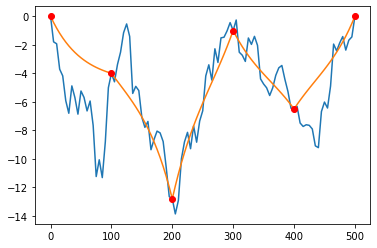

In [75]:
simu, mu = Zunk_mu()
Ec2 = esperance_cond(mu)

allval3_bis = np.zeros(N)
allval3_bis[unknown_indexes]=simu
allval3_bis[observation_indexes]=depth
plt.plot(discretization,allval3_bis)

allval1_bis = np.zeros(N)
allval1_bis[unknown_indexes]= Ec2
allval1_bis[observation_indexes]=depth
plt.plot(discretization,allval1_bis)

plt.plot(discretization[observation_indexes], depth, 'ro')
plt.show()

9. Générer 10000 profils de profondeur et calculer les longueurs de câble associées. Comparer la valeur moyenne de la longueur de câble, dont on visualisera la convergence, l'histogramme des longueurs de câble, l'intervalle de confiance obtenu par la méthode des quantiles, la probabilité de dépassement du seuil de 525 m avec les résultats obtenus précédemment. Commenter.

In [76]:
K=10000
result = np.zeros(K)
for i in range(K):
    simu, mu = Zunk_mu()
    allval3[unknown_indexes]= simu
    result[i]=length(allval3,Delta)

In [77]:
sum(result)/K

521.7448677956138

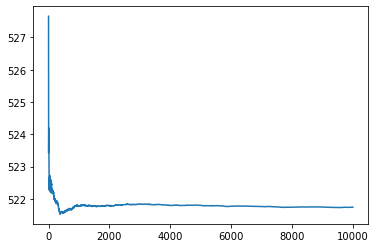

In [78]:
indice_simu = 1+np.arange(K)
plt.plot(indice_simu,np.cumsum(result)/indice_simu)
plt.show()

In [79]:
np.mean(result>525)

0.1255

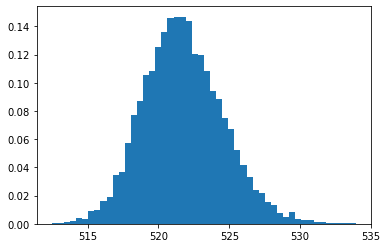

In [80]:
plt.hist(result,50,density=True)
plt.show()

In [81]:
np.quantile(result,[0.025,0.975])

array([516.61315413, 527.64141735])

Les résultats obtenus sont simillaires aux résultats trouvés à la question 2. Cela montre que l'espérance qui était fixée 
reflète bien la situation réelle. 

10. Qu'adviendrait-il selon vous si on rendait également aléatoires les autres paramètres du modèle $\sigma^2$ et $a$ ?

Si on rendait aléatoire les autres paramètres, il est possible que nous observerions plus de fluctuations et que ce phénomène se rétablisse pour un grand nombre d'estimations car les variables se rapprocheraient alors de leur valeur moyenne.